In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import neighbors, datasets, preprocessing
from sklearn.model_selection import train_test_split
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB 

from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import recall_score
from sklearn.model_selection import cross_val_score
import seaborn as sns

In [29]:
churn_original = pd.read_csv("customer_churn.csv")
churn = churn_original.copy()

churn.head()

,State,Account Length,Area Code,Phone,Int'l Plan,VMail Plan,VMail Message,Day Mins,Day Calls,Day Charge,...,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls,Churn?
0,KS,128,415,382-4657,no,yes,25,265.1,110,45.07,...,99,16.78,244.7,91,11.01,10.0,3,2.70,1,False.
1,OH,107,415,371-7191,no,yes,26,161.6,123,27.47,...,103,16.62,254.4,103,11.45,13.7,3,3.70,1,False.
2,NJ,137,415,358-1921,no,no,0,243.4,114,41.38,...,110,10.30,162.6,104,7.32,12.2,5,3.29,0,False.
3,OH,84,408,375-9999,yes,no,0,299.4,71,50.90,...,88,5.26,196.9,89,8.86,6.6,7,1.78,2,False.
4,OK,75,415,330-6626,yes,no,0,166.7,113,28.34,...,122,12.61,186.9,121,8.41,10.1,3,2.73,3,False.


In [3]:
# The first step in our analysis would be to check how many values are missing in each column 
churn.isnull().sum()

State             0
Account Length    0
Area Code         0
Phone             0
Int'l Plan        0
VMail Plan        0
VMail Message     0
Day Mins          0
Day Calls         0
Day Charge        0
Eve Mins          0
Eve Calls         0
Eve Charge        0
Night Mins        0
Night Calls       0
Night Charge      0
Intl Mins         0
Intl Calls        0
Intl Charge       0
CustServ Calls    0
Churn?            0
dtype: int64

In [4]:
# Now, let's look at the statistics for the data set
churn.describe()

,Account Length,Area Code,VMail Message,Day Mins,Day Calls,Day Charge,Eve Mins,Eve Calls,Eve Charge,Night Mins,Night Calls,Night Charge,Intl Mins,Intl Calls,Intl Charge,CustServ Calls
count,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000,3333.000000
mean,101.064806,437.182418,8.099010,179.775098,100.435644,30.562307,200.980348,100.114311,17.083540,200.872037,100.107711,9.039325,10.237294,4.479448,2.764581,1.562856
std,39.822106,42.371290,13.688365,54.467389,20.069084,9.259435,50.713844,19.922625,4.310668,50.573847,19.568609,2.275873,2.791840,2.461214,0.753773,1.315491
min,1.000000,408.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,23.200000,33.000000,1.040000,0.000000,0.000000,0.000000,0.000000
25%,74.000000,408.000000,0.000000,143.700000,87.000000,24.430000,166.600000,87.000000,14.160000,167.000000,87.000000,7.520000,8.500000,3.000000,2.300000,1.000000
50%,101.000000,415.000000,0.000000,179.400000,101.000000,30.500000,201.400000,100.000000,17.120000,201.200000,100.000000,9.050000,10.300000,4.000000,2.780000,1.000000
75%,127.000000,510.000000,20.000000,216.400000,114.000000,36.790000,235.300000,114.000000,20.000000,235.300000,113.000000,10.590000,12.100000,6.000000,3.270000,2.000000
max,243.000000,510.000000,51.000000,350.800000,165.000000,59.640000,363.700000,170.000000,30.910000,395.000000,175.000000,17.770000,20.000000,20.000000,5.400000,9.000000


In [30]:
#this is to clean up the column names and replace binary word values with [1,0]
churn.columns = churn.columns.str.strip().str.lower().str.replace(' ', '_').str.replace('(', '').str.replace(')', '').str.replace('?','').str.replace('\'','')
churn.churn.replace(['True.','False.'], [1, 0], inplace=True)
churn.intl_plan.replace(['yes','no'], [1, 0], inplace=True)
churn.vmail_plan.replace(['yes','no'], [1, 0], inplace=True)

#Next, we want to convert the values in the states column into a numerical value
unique_states = churn['state'].unique()
unique_states.sort()

result = []
counter = 1

for state in unique_states:
    result.append((state,counter))
    counter += 1

d_result = dict(result)

churn['state'].replace(d_result,inplace = True)

#Remove phone since this would be a unique number and doesnt convey much information. 
churn.drop(['phone'],axis=1, inplace=True)

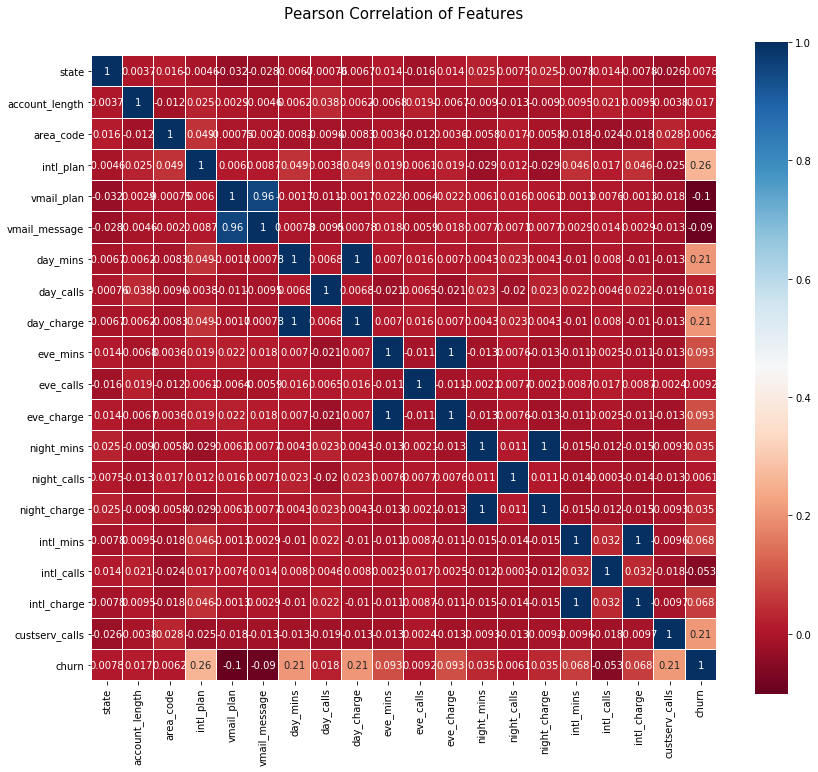

In [20]:
#Creating a correlation heat map that helps us with data cleaning
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(churn.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [40]:
#making a cleaned copy of the dataset that drops unnecessary features
churn_cleaned = churn.copy()
churn_cleaned['domestic_calls'] = churn['day_calls'] + churn['night_calls'] + churn['eve_calls']
churn_cleaned.drop(['state','account_length','area_code','vmail_message','day_calls','day_charge',
                    'eve_calls','eve_charge','night_calls','night_charge','intl_charge'],axis=1, inplace=True)

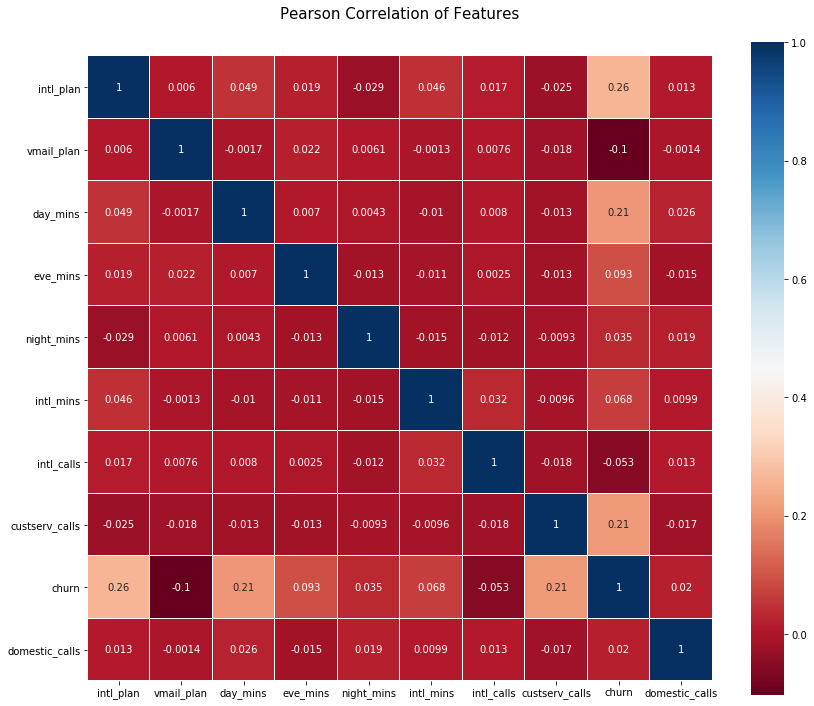

In [41]:
#creating a heat map of the cleaned dataset
colormap = plt.cm.RdBu
plt.figure(figsize=(14,12))
plt.title('Pearson Correlation of Features', y=1.05, size=15)
sns.heatmap(churn_cleaned.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

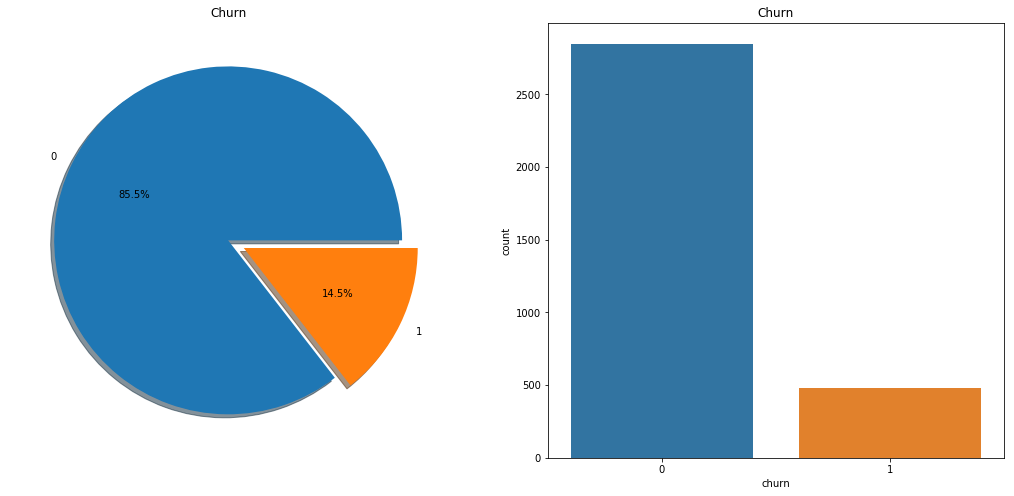

In [9]:
f,ax=plt.subplots(1,2,figsize=(18,8))
churn['churn'].value_counts().plot.pie(explode=[0,0.1],autopct='%1.1f%%',ax=ax[0],shadow=True)
ax[0].set_title('Churn')
ax[0].set_ylabel('')
sns.countplot('churn',data=churn,ax=ax[1])
ax[1].set_title('Churn')
plt.show()

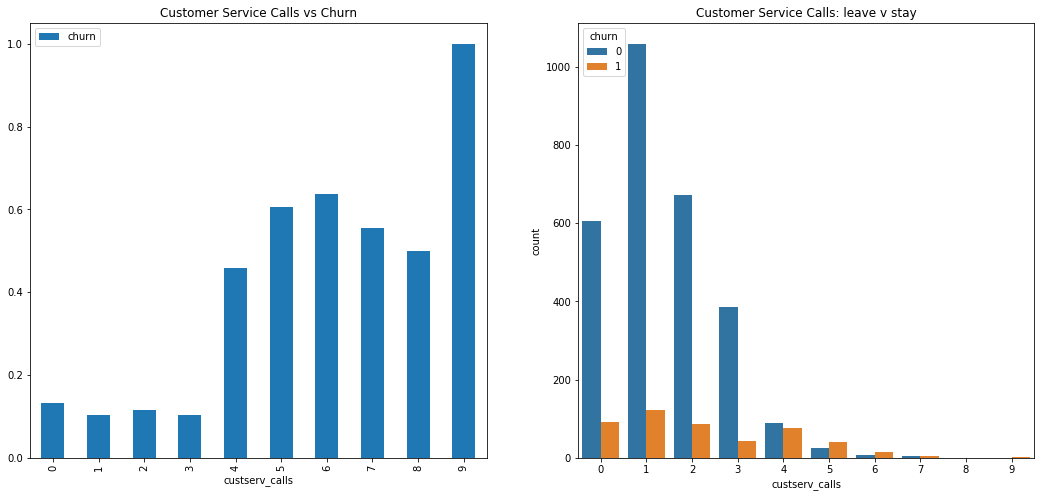

In [10]:
f,ax=plt.subplots(1,2,figsize=(18,8))
churn[['custserv_calls','churn']].groupby(['custserv_calls']).mean().plot.bar(ax=ax[0])
ax[0].set_title('Customer Service Calls vs Churn')
sns.countplot('custserv_calls',hue='churn',data=churn,ax=ax[1])
ax[1].set_title('Customer Service Calls: leave v stay')
plt.show()

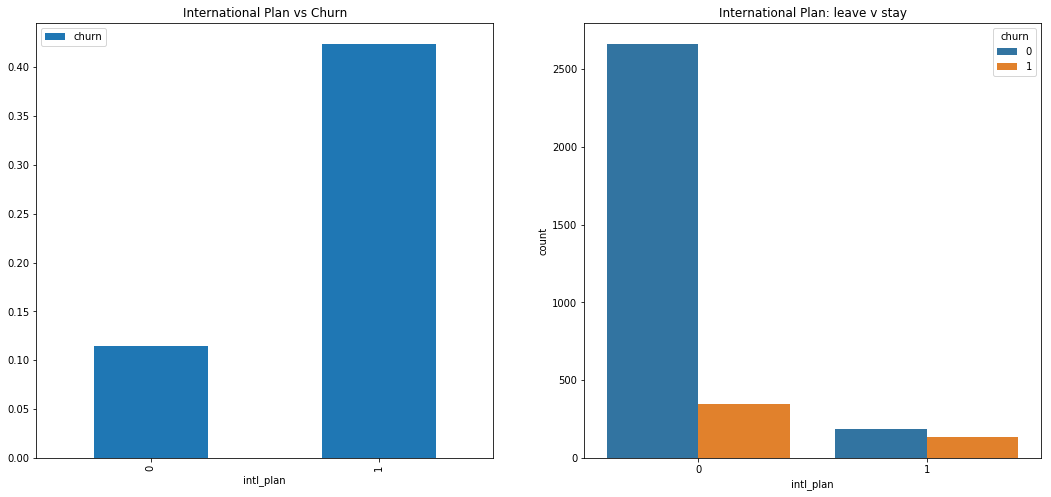

In [11]:
f,ax=plt.subplots(1,2,figsize=(18,8))
churn[['intl_plan','churn']].groupby(['intl_plan']).mean().plot.bar(ax=ax[0])
ax[0].set_title('International Plan vs Churn')
sns.countplot('intl_plan',hue='churn',data=churn,ax=ax[1])
ax[1].set_title('International Plan: leave v stay')
plt.show()

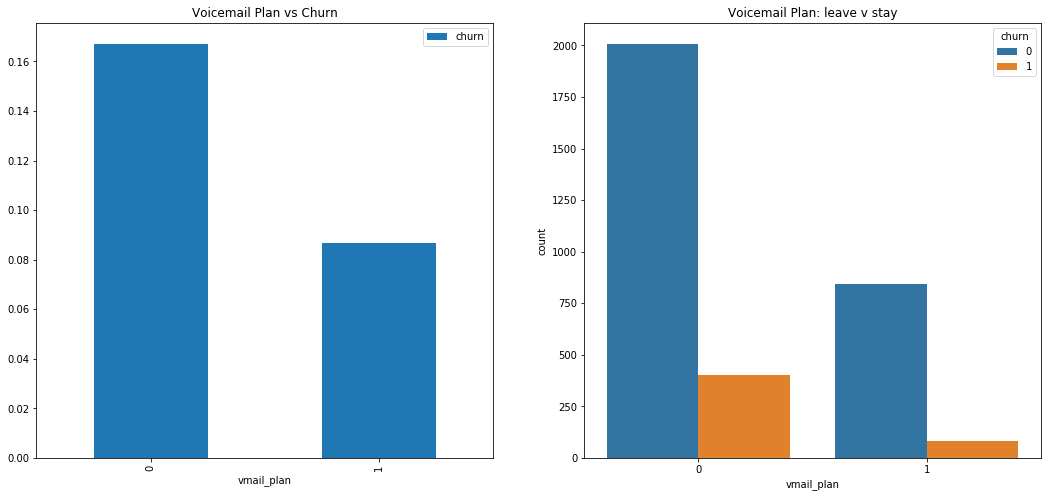

In [12]:
f,ax=plt.subplots(1,2,figsize=(18,8))
churn[['vmail_plan','churn']].groupby(['vmail_plan']).mean().plot.bar(ax=ax[0])
ax[0].set_title('Voicemail Plan vs Churn')
sns.countplot('vmail_plan',hue='churn',data=churn,ax=ax[1])
ax[1].set_title('Voicemail Plan: leave v stay')
plt.show()

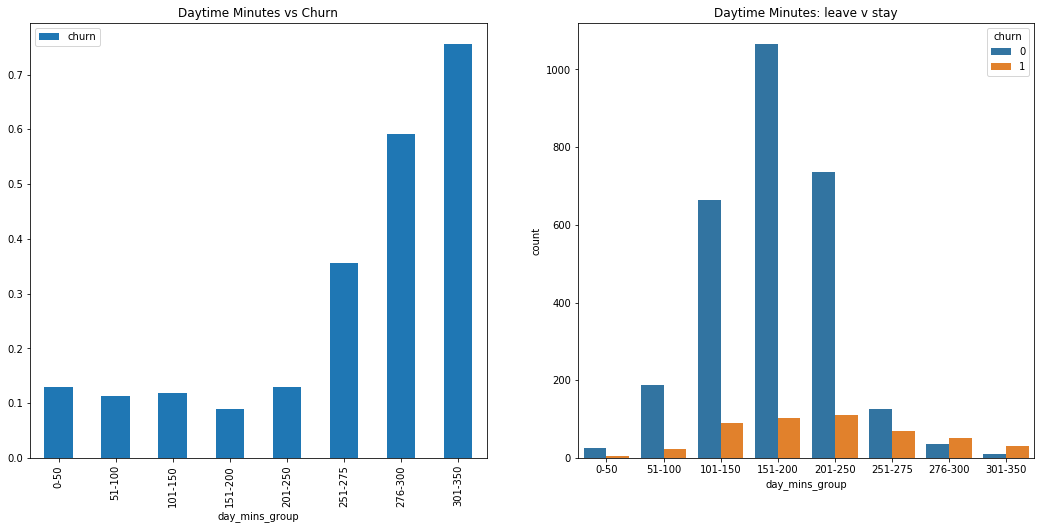

In [13]:
bins = [0,51,101,151,201,251,276,301,351]
bin_labels = ['0-50','51-100', '101-150','151-200','201-250','251-275','276-300','301-350']
churn['day_mins_group'] = pd.cut(churn.day_mins, bins, right=False, labels = bin_labels)

f,ax=plt.subplots(1,2,figsize=(18,8))
churn[['day_mins_group','churn']].groupby(['day_mins_group']).mean().plot.bar(ax=ax[0])
ax[0].set_title('Daytime Minutes vs Churn')
sns.countplot('day_mins_group',hue='churn',data=churn,ax=ax[1])
ax[1].set_title('Daytime Minutes: leave v stay')
plt.show()

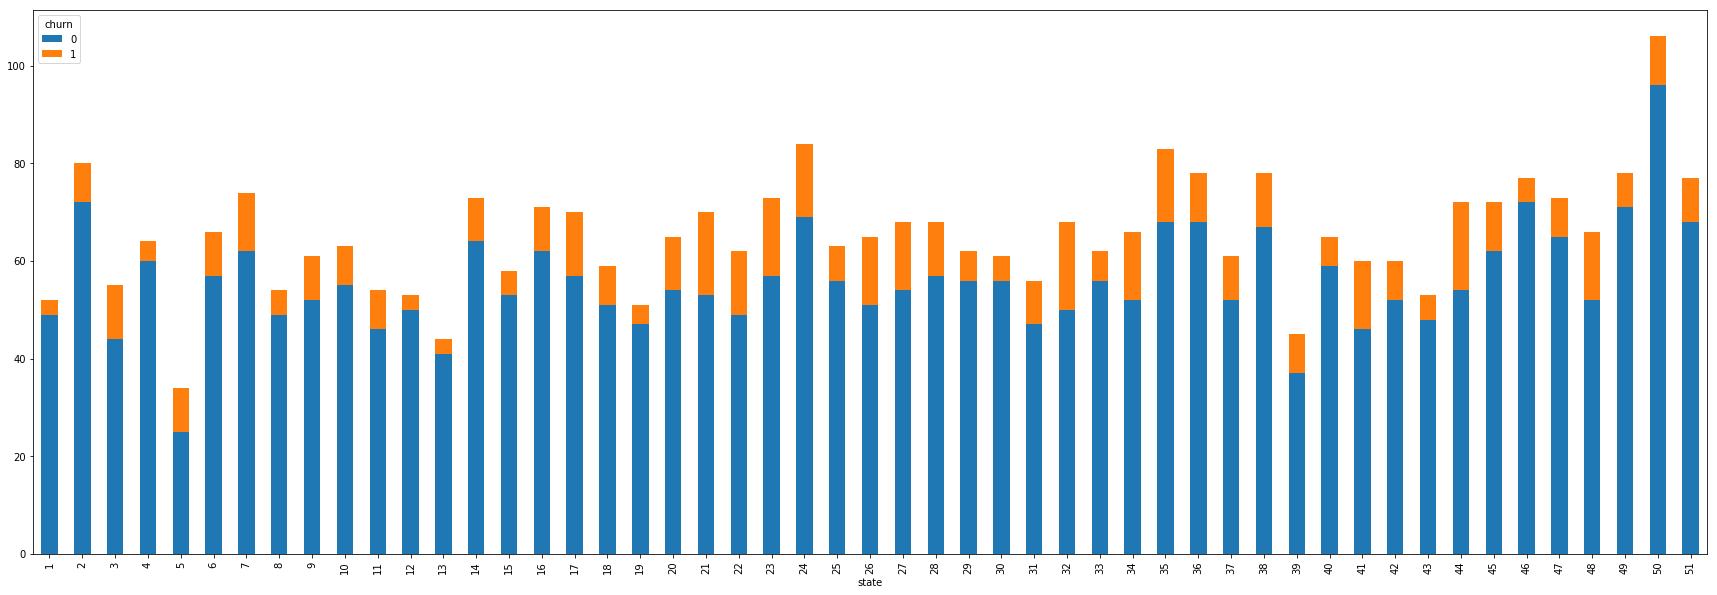

In [14]:
churn.groupby(["state", "churn"]).size().unstack().plot(kind='bar', stacked=True, figsize=(30,10))

# Model Selection

## Baseline Model - Decision Tree

In [76]:
churn_base_model = churn.copy() #makes a copy of the churn data set to be used for the base model
churn_base_model.drop(['churn'],axis=1, inplace=True) #drops the target variable

x = churn_base_model
y = churn['churn']

x_Train, x_Test, y_Train, y_Test = train_test_split(x, y, test_size = 0.3, random_state=0)

dtree_base = DecisionTreeClassifier(max_depth=3)
dtree_base.fit(x_Train,y_Train)
predictions_base = dtree_base.predict(x_Test)
print(classification_report(y_Test,predictions_base))
print(confusion_matrix(y_Test,predictions_base))
print(accuracy_score(y_Test,predictions_base))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95       862
           1       0.86      0.41      0.56       138

   micro avg       0.91      0.91      0.91      1000
   macro avg       0.89      0.70      0.75      1000
weighted avg       0.91      0.91      0.90      1000

[[853   9]
 [ 81  57]]
0.91


In [77]:
#10-Fold Cross Validation Model
scores = cross_val_score(dtree_base, x, y, cv=10) 
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[0.9011976  0.89820359 0.9011976  0.89489489 0.91291291 0.89489489
 0.8978979  0.89489489 0.8978979  0.93093093]
Accuracy: 0.90 (+/- 0.02)


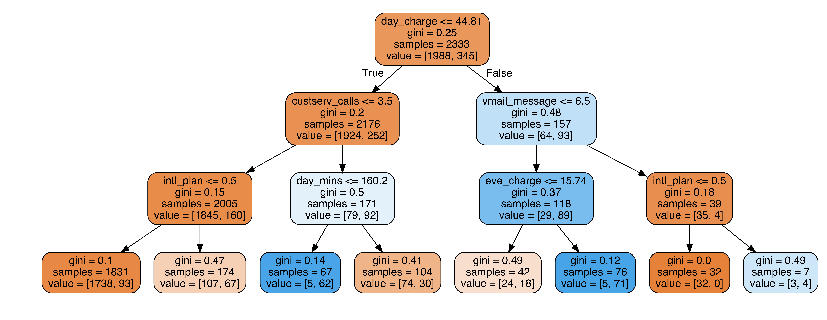

In [25]:
from sklearn.tree import export_graphviz
export_graphviz(dtree_base, out_file='tree.dot', 
                feature_names = x.columns,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

import matplotlib.pyplot as plt
plt.figure(figsize = (14, 18))
plt.imshow(plt.imread('tree.png'))
plt.axis('off');
plt.show();

## Decision Tree

In [47]:
X = churn_cleaned[['intl_plan','vmail_plan','day_mins','night_mins','eve_mins','intl_mins',
                   'intl_calls','domestic_calls','custserv_calls']]
Y = churn_cleaned['churn']

X_Train, X_Test, Y_Train, Y_Test = train_test_split(X, Y, test_size = 0.3, random_state=0)

dtree = DecisionTreeClassifier(max_depth=3)
dtree.fit(X_Train,Y_Train)
prediction_dtree = dtree.predict(X_Test)
print(classification_report(Y_Test,prediction_dtree))
print(confusion_matrix(Y_Test,prediction_dtree))
print(accuracy_score(Y_Test,prediction_dtree))

              precision    recall  f1-score   support

           0       0.91      0.99      0.95       862
           1       0.86      0.41      0.56       138

   micro avg       0.91      0.91      0.91      1000
   macro avg       0.89      0.70      0.75      1000
weighted avg       0.91      0.91      0.90      1000

[[853   9]
 [ 81  57]]
0.91


In [48]:
scores = cross_val_score(dtree, X, Y, cv=10)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[0.9011976  0.89820359 0.9011976  0.89489489 0.91291291 0.89489489
 0.8978979  0.89489489 0.8978979  0.93093093]
Accuracy: 0.90 (+/- 0.02)


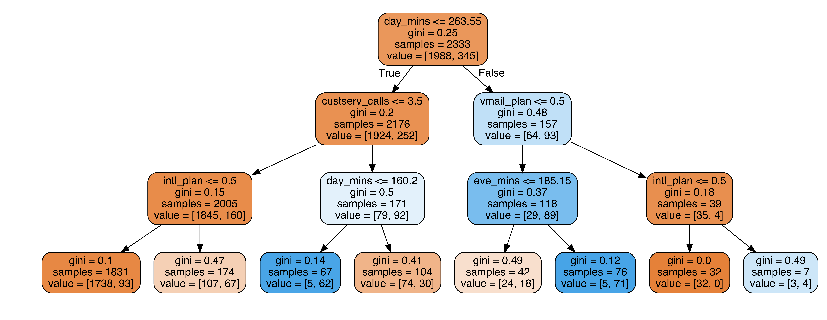

In [49]:
from sklearn.tree import export_graphviz
export_graphviz(dtree, out_file='tree.dot', 
                feature_names = X.columns,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

import matplotlib.pyplot as plt
plt.figure(figsize = (14, 18))
plt.imshow(plt.imread('tree.png'))
plt.axis('off');
plt.show();

## Random Forest

In [50]:
random_forest = RandomForestClassifier(n_estimators=300)

random_forest.fit(X_Train, Y_Train)

predictions_RF = random_forest.predict(X_Test)

print(classification_report(Y_Test,predictions_RF))
print(confusion_matrix(Y_Test,predictions_RF))
print(accuracy_score(Y_Test, predictions_RF))

              precision    recall  f1-score   support

           0       0.97      0.99      0.98       862
           1       0.92      0.80      0.85       138

   micro avg       0.96      0.96      0.96      1000
   macro avg       0.94      0.89      0.92      1000
weighted avg       0.96      0.96      0.96      1000

[[852  10]
 [ 28 110]]
0.962


In [51]:
scores = cross_val_score(random_forest, X, Y, cv=10)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2)) 

[0.94610778 0.96107784 0.94311377 0.94294294 0.97297297 0.96996997
 0.95795796 0.95195195 0.94894895 0.97597598]
Accuracy: 0.96 (+/- 0.02)


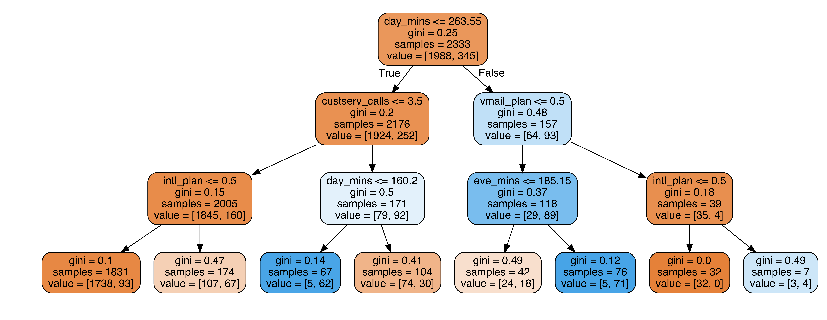

In [56]:
#selects a random decision tree from the random forest and visualizes it
from random import randint
estimator = random_forest.estimators_[randint(1,300)]

from sklearn.tree import export_graphviz
export_graphviz(estimator, out_file='tree1.dot', 
                feature_names = X.columns,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png
from subprocess import call
call(['dot', '-Tpng', 'tree.dot', '-o', 'tree.png', '-Gdpi=600'])

import matplotlib.pyplot as plt
plt.figure(figsize = (14, 18))
plt.imshow(plt.imread('tree.png'))
plt.axis('off');
plt.show();

## Logistic Regression

In [200]:
# instantiate the model (using the default parameters)
logreg = LogisticRegression()

# fit the model with data
logreg.fit(X_Train,Y_Train)


predictions_logreg = logreg.predict(X_Test)
print(accuracy_score(Y_Test,predictions_logreg))
print(classification_report(Y_Test,predictions_logreg))
print(confusion_matrix(Y_Test,predictions_logreg))


0.869
              precision    recall  f1-score   support

           0       0.88      0.98      0.93       862
           1       0.59      0.17      0.27       138

   micro avg       0.87      0.87      0.87      1000
   macro avg       0.73      0.58      0.60      1000
weighted avg       0.84      0.87      0.84      1000

[[845  17]
 [114  24]]


/Users/enzo/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [201]:
scores = cross_val_score(logreg, X, Y, cv=10)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

/Users/enzo/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/enzo/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/enzo/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/enzo/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/enzo/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 

[0.84431138 0.8742515  0.85928144 0.85285285 0.85585586 0.85585586
 0.87087087 0.86786787 0.86186186 0.84984985]
Accuracy: 0.86 (+/- 0.02)


/Users/enzo/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/Users/enzo/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


## Gaussian Naive Bayes

In [218]:
model = GaussianNB()
model.fit(X_Train, Y_Train)
predictions_GNB = model.predict(X_Test)
print(classification_report(Y_Test, predictions_GNB))
print(confusion_matrix(Y_Test,predictions_GNB))
accuracy_score(Y_Test,predictions_GNB)

              precision    recall  f1-score   support

           0       0.91      0.91      0.91       862
           1       0.44      0.42      0.43       138

   micro avg       0.85      0.85      0.85      1000
   macro avg       0.67      0.67      0.67      1000
weighted avg       0.84      0.85      0.84      1000

[[788  74]
 [ 80  58]]


0.846

In [217]:
scores = cross_val_score(model, X, Y, cv=10)
print(scores)
print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))

[0.8502994  0.85928144 0.83832335 0.83183183 0.85585586 0.84684685
 0.85885886 0.85285285 0.85885886 0.84084084]
Accuracy: 0.85 (+/- 0.02)
